# Libraries

In [1]:
# Data-handling libraries
import pandas as pd

# Text-handling libraries
from nltk.text import Text, TextCollection
from nltk.tokenize import RegexpTokenizer
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from unidecode import unidecode

# Other imports
import re
import matplotlib.pyplot as plt

In [2]:
plt.style.reload_library()
plt.style.use("alex")

# Data Import

In [3]:
# Data source: http://menus.nypl.org/data
menu = pd.read_csv("data/Menu.csv.bz2")
dish = pd.read_csv("data/Dish.csv.bz2")
menu_item = pd.read_csv("data/MenuItem.csv.bz2")
menu_page = pd.read_csv("data/MenuPage.csv.bz2")

# Data Cleaning

## Shape data

In [4]:
# Add menu id to each menu item
df = pd.merge(
    menu_item[["dish_id", "menu_page_id"]],
    menu_page[["id", "menu_id"]],
    how = "right",
    left_on = "menu_page_id",
    right_on = "id"
)

# Add menu date to each menu id
df = pd.merge(
    df,
    menu[["id", "date"]],
    how = "right",
    left_on = "menu_id",
    right_on = "id"
)

# Add dish name to each menu item
df = pd.merge(
    df,
    dish[["id", "name"]],
    how = "right",
    left_on = "dish_id",
    right_on = "id"
)

# Remove intermediate columns
df = df[["name", "date", "menu_id"]]

# Delete our original imports to free up memory
del menu
del dish
del menu_item
del menu_page

In [5]:
# Drop malformed dates
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [6]:
# Drop 68438 unknown and 638 malformed dates (≈ 5%)
df.dropna(inplace=True)

In [7]:
# Calculate year and decade
df["year"] = pd.DatetimeIndex(df["date"]).year
df["decade"] = df["year"] // 10 * 10

Text(0, 0.5, 'No. menu items')

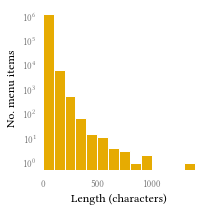

In [9]:
df["name"].str.len().hist(log=True, grid=False, bins=np.arange(0, 1500, 100), figsize=(3, 3), color="C5", edgecolor="#ffffff");
plt.xlabel("Length (characters)")
plt.ylabel("No. menu items")

In [10]:
print(df[df["name"].str.len() <= 100]["name"].str.len().sum())
print(df[df["name"].str.len() > 100]["name"].str.len().sum())

24868163
950963


## Replace special characters

In [11]:
df["name"] = df["name"].apply(unidecode)

In [12]:
# Confirm that we got all non-ASCII characters
df[df["name"].str.contains("[^\x00-\x7F]")]

,name,date,menu_id,year,decade


## Tokenize etc.

In [13]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer("[a-z'-]+")
stopwords = set(stopwords.words("english"))

def tokenize(text):
    tokens = set(tokenizer.tokenize(text))    
    return " ".join(tokens - stopwords)

df["name"] = df["name"].str.lower()
df["tokens"] = df["name"].apply(tokenize)

## Write out cleaned data

In [14]:
df.drop(columns="date").to_csv("data/Dishes-by-year.csv.bz2", compression="bz2", index=False)

# EDA

In [15]:
# For histogram bins
decades = range(1850, 2030, 10)

## Dates

[Text(0, 0, ''),
 Text(0, 0, '100k'),
 Text(0, 0, '200k'),
 Text(0, 0, '300k'),
 Text(0, 0, '400k')]

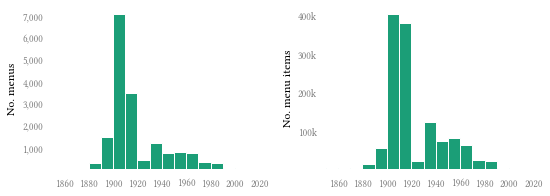

In [16]:
import matplotlib.ticker as mtick

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

df.groupby("menu_id").mean()["year"].hist(bins=decades, grid=False, color="C0", edgecolor="white", ax=ax1);
ax1.set_xticks(decades[1::2])
ax1.set_yticks(range(1000, 7001, 1000))
ax1.set_ylabel("No. menus")
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

df["year"].hist(bins=decades, grid=False, color="C0", edgecolor="white", ax=ax2);
ax2.set_ylabel("No. menu items")
ax2.set_xticks(decades[1::2])
ax2.set_yticklabels(["", "100k", "200k", "300k", "400k"])

## Menus

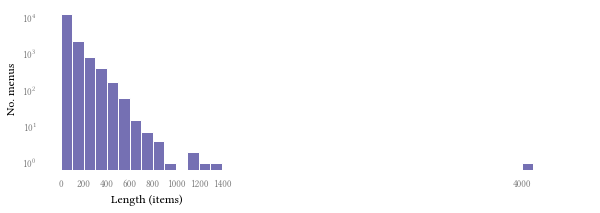

In [17]:
#plt.title("Menu length distribution", fontsize=20)
fig, ax = plt.subplots()
df.groupby("menu_id").count()["name"].hist(log=True, grid=False, bins=np.arange(0, 4500, 100), figsize=(10, 3), color="C2", edgecolor="white");
plt.xlabel("Length (items)")
ax.xaxis.set_label_coords(0.2, -0.15)
plt.ylabel("No. menus")
plt.xticks(list(np.arange(0, 1600, 200)) + [4000])
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/menu-item-length.svg")

## Dishes

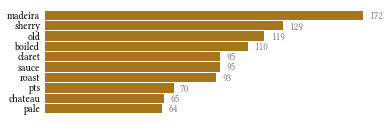

In [19]:
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.color"] = "#090A0C"

decade = 1850

words = " ".join(df[df["decade"]==decade]["tokens"])
freqs = pd.Series(words.split())\
        .value_counts()\
        .sort_values()\
        .tail(10)

ax = freqs.plot.barh(color="C6", figsize=(6, 2), width=1, edgecolor="white");
ax.set_xticks([])

# <https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html>

totals = [i.get_width() for i in ax.patches]

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        x = i.get_width() + (freqs.max() / 50),
        y = i.get_y() + 0.1,
        s = "{:,}".format(i.get_width()),
        color="gray"
    )

In [22]:
words = {}
freqs = {}

for decade in range(1850, 2020, 10):
    
    words[decade] = " ".join(df[df["decade"]==decade]["tokens"])
    freqs[decade] = pd.Series(words[decade].split())\
                    .value_counts()\
                    .sort_values()\
                    .tail(10)
    
# This was supposed to be a frequency line plot against decades... maybe forthcoming

In [25]:
words = ["jell-o", "pork"]

counts = {word: df["tokens"].str.contains(f"\\b{word}\\b") for word in words}
occ = pd.DataFrame(counts).join(df["year"])

,jell-o,pork,year
0,False,False,1900
1,False,False,1900
2,False,False,1906
3,False,False,1900
4,False,False,1897
...,...,...,...
1328795,False,False,1987
1328796,False,False,1987
1328797,False,False,1987
1328798,False,False,1987


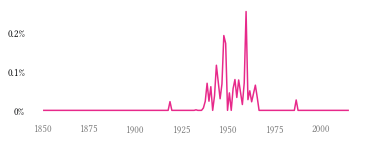

In [21]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(color = ["#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666"])

words = ["jell-o"]

counts = {word: df["tokens"].str.contains(f"\\b{word}\\b") for word in words}
occ = pd.concat([df["year"], pd.DataFrame(counts)], axis=1)

ax = occ.groupby("year").mean().apply(lambda x: x*100).plot(figsize=(6, 2), legend=False)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%g%%"));
ax.set_xlabel("");

AttributeError: module 'matplotlib.pyplot' has no attribute 'density'

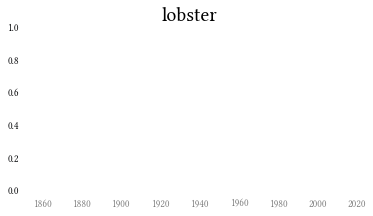

In [164]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(color = ["#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666"])

for group in [
#     ["chicken", "pork"],
#     ["coffee", "tea"],
#     ["tomato"],
#     ["vanilla", "chocolate"],
#     ["jell-?o"],
#     ["cod", "salmon", "trout"],
#     ["lobster"],
#     ["boiled"],
#     ["fricass[eé]e"],
#     ["sauce"],
#     ["reduction", "marinated"],
#     ["soy", "tofu"],
#     ["local", "organic"],
#     ["umami"],
#     ["macaroni"],
    ["lobster"]
]:
    plt.figure(figsize=(6, 3))
    plt.title(", ".join(group), fontsize=20)

    for term in group:
        # We want proportions of menus since we have many more from some decades than from others (see above hist)
        prop_dishes = df[df["name"].str.contains(term)].groupby("decade").sum() / df.groupby("decade").sum()
        prop_menus = df[df["name"].str.contains(term)].groupby("decade").count()["menu_id"] / df.groupby("decade").count()["menu_id"]

        plt.xticks(decades[1::2])
        plt.xlim((1850, 2020))
        plt.plot(prop_menus, label=term)
        
    plt.legend()
    #display(df.groupby("decade").sum())